# ECON622: Computational Economics with Data Science Applications

Generalization, Deep Learning, and Representations

Jesse Perla (University of British Columbia)

# Overview

## Summary

-   Step back from optimization and fitting process to discuss the
    broader issues of statistics and function approximation
-   Key topics:
    -   ERM, interpolation, and generalization error
    -   Features and Representations
    -   Neural Networks and broader hypothesis classes
-   In the subsequent lecture we can briefly return to the optimization
    process itself to discuss
    -   Global vs. Local solutions
    -   Inductive bias and regularization

## Packages

In [1]:
import jax
import jax.numpy as jnp
import numpy as np
from jax import random
import optax
import jax_dataloader as jdl
from jax_dataloader.loaders import DataLoaderJAX
from flax import nnx
import torch
import torch.nn as nn
import copy

# Neural Networks, Part I

## Neural Networks Include Almost Everything

-   **Neural Networks** as just an especially flexible functional form
    -   Linear, polynomials, and all of our standard approximation fit
        in there
-   However, when we say “Neural Network” you should have in mind
    approximations that are typically
    -   parameterized by some complicated:
        $\theta \equiv \{\theta_1, \theta_2, \cdots, \theta_L\}$
    -   nested with **layers**:
        $y = f_1(f_2(\ldots f_L(x;\theta_L);\theta_2);\theta_1) \equiv f(x;\theta)$
    -   **highly overparameterized**, such that $\theta$ is often
        massive, often far larger than the amount of data
-   Terminology: **depth** is number of layers $L$, **width** is the
    size of $\theta_{\ell}$

## (Asymptotic) Universal Approximation Theorems

-   At this point you may expect a theorem that says that neural
    networks are [**universal
    approximators**](https://en.wikipedia.org/wiki/Universal_approximation_theorem#Arbitrary-width_case).
    e.g., Cybenko, Hornik, and others
    -   i.e., for any function $f^*(x)$, there exists a neural network
        $f(x;\theta)$ that can approximate it arbitrarily well
    -   Takes limits of the number of parameters at each layer
        (e.g. $\theta_{\ell}\nearrow$), or sometimes the number of
        layers (e.g. $L\nearrow$)
-   A low bar to pass that rarely gives useful guidance or bounds
    -   We do not use enormously “wide” approximations
    -   The theorems are too pessimistic, as NNs do much better in
        practice
    -   Important when doing core functional analysis and asymptotics

## How Can we Fit Huge Approximations?

-   At this point you should not be scared off by a big $\theta$
-   The ML and deep-learning revolution is built on ideas you have
    covered
    -   With a scalar loss $L(\theta)$, you can use VJPs (reverse-mode
        AD) to get gradients $\nabla_{\theta} L(\theta)$
    -   AD software like PyTorch or JAX makes it easy to collect the
        $\theta$ and run the AD on complicated $L(\theta)$
    -   Hardware (e.g. GPUs) can make common operations like VJPs fast
    -   Optimization methods like SGD work great, using gradient
        estimates when memory is an issue for the full
        $\nabla_{\theta} L(\theta)$
    -   Regularization, in all its forms, helps when used appropriately
-   But that doesn’t explain why this can help generalization
    performance?

## Puzzling Empirical Success, Ahead of Theory

-   Deep learning and AD are old, but only recently have the software
    and hardware been good enough to scale
-   Bias-variance tradeoff: adding parameters can make things worse
    -   But ML practitioners often find the opposite **empirically**
    -   Frequent success with lots of layers and massive
        over-parameterization
    -   This seems counter to all sorts of basic statistics intuition
-   ML theory is still catching up to the empirical success
    -   We will try to give some perspectives on **when/why deep
        learning works**
    -   First, we will have to be precise on what we mean by “works”

# ERM and Interpolation

## Estimation and Interpolation Setup

-   See [ProbML Book 1](https://probml.github.io/pml-book/book1.html)
    Section 5.4 on ERM
-   Generalizing that notation somewhat to better nest functional
    equations
    -   Let $p^*(x,y)$ be the **true** distribution on inputs
        $x \in \mathcal{X}$ and outputs $y \in \mathcal{Y}$
    -   Let $f : \mathcal{X} \to \mathcal{Y}$ be a function mapping
        inputs to outputs. For example, maybe $\hat{y} = f(x)$ is an
        estimator for the relationship between $x$ and $y$ in $p^*(x,y)$
    -   For now, assume that $f \in \mathcal{F}$ for some very large set
        of functions appropriate to the problem (e.g., Sobolev space,
        etc.)
    -   Define the loss as an operator $(f, x, y) \to \ell(f, x, y)$
        -   For example, $\ell(f, x, y) = (y - f(x))^2$ for LLS

## Population Risk

-   The **population risk** is then defined as

$$
R(f, p^*) \equiv \mathbb{E}_{p^*(x,y)}\left[\ell(f, x, y)\right]
$$

-   This lets us define the ideal minimizer of the population risk as

$$
f^{**} = \arg\min_{f \in \mathcal{F}} R(f, p^*)
$$

-   If $\min_{f \in \mathcal{F}} R(f, p^*) = 0$, there is an
    interpolating solution across the whole of $p^*$. Common with
    functional equations, rare in statistics applications

## Functional Equations

-   The deviations from the ProbML book are to ensure we can nest
    solving functional equations. In that case, we can drop the $y$.
-   We can loosely think of $f$ as solving the functional equation as
    long as

$$
\min_{f \in \mathcal{F}} R(f, p^*) \equiv \min_{f \in \mathcal{F}} \mathbb{E}_{p^*(x)}\left[\ell(f, x)\right] = 0
$$

-   Set the function class $\mathcal{F}$ to be consistent with the
    $\ell$
    -   e.g., for $\ell(f,x) = (\partial_x f(x) - a f(x))^2$ choose a
        Sobolev $\mathcal{F}$
    -   We are leaving it out here, but you might add on other terms
        like boundary conditions to the $R(f,p^*)$ loss
    -   Note the key difference relative to standard methods is the
        $p^*(x)$!

## Empirical Risk

-   Denote $N$ samples from $p^*(x,y)$ as
    $\mathcal{D} \equiv \{x_n, y_n\}_{n=1}^N$
-   We can think of this as empirical distribution
    $p_{\mathcal{D}}(x,y)$
-   Which lets us define the **empirical risk**

$$
R(f, \mathcal{D}) \equiv \frac{1}{N}\sum_{n=1}^N \ell(f, x_n, y_n) = R(f, p_{\mathcal{D}}) 
$$

-   Note that the empirical risk is decoupled from the function space of
    $f$ and simply captures the role of finite-samples from $p^*(x,y)$

## Hypothesis Class

-   If $\mathcal{F}$ is too large then it may be hard to solve, or we
    may introduce errors due to overfitting
-   Instead, consider a **hypothesis class**
    $\mathcal{H}\subseteq \mathcal{F}$, which is parameterized in
    practice by $\theta \in \Theta$
-   For example, we might choose an $\mathcal{H}$ that is a
    -   Linear function
    -   Orthogonal polynomial
    -   Neural network with large number of parameters and
        nonlinearities

## Empirical Risk Minimization

-   Finally, we can now look at the **empirical risk minimization**
    problem, which is the core of most statistical estimation problems
    like regressions

$$
f^*_{\mathcal{D}} = \arg\min_{f \in \mathcal{H}} R(f, \mathcal{D}) = \arg\min_{f \in \mathcal{H}}\frac{1}{N}\sum_{n=1}^N \ell(f, x_n, y_n)
$$

-   If the $\mathcal{H}(\Theta)$, then we could implement this as

$$
\arg\min_{\theta \in \Theta} \frac{1}{N}\sum_{n=1}^N \ell(f_{\theta}, x_n, y_n)
$$

## Linear Least Squares

-   For example, if
    -   $\mathcal{H}(\Theta)$ only includes linear functions
        -   i.e. $f_{\theta}(x) = \theta \cdot x$ for some
            $\theta \in \Theta$
    -   $\ell(f, x, y) = (y - f(x))^2$
-   Then this problem is just OLS
    -   $\arg\min_{\theta \in \Theta} \frac{1}{N}\sum_{n=1}^N (y_n - \theta \cdot x_n)^2$
-   Economists are very good at analyzing the properties of the
    $\mathcal{D}$ in $p^*(x,y)$ but often ignore the differences between
    $\mathcal{H}$ vs. $\mathcal{F}$?
-   In contrast: for solving functional equations, we are better at
    analyzing $\mathcal{F}$ vs. $\mathcal{H}$, but typically implicitly
    assume a uniform $p^*(x)$

## Approximation Error

-   To evaluate what we lose by using $\mathcal{H}$ instead of
    $\mathcal{F}$, we can define

$$
f^* \equiv \arg\min_{f \in \mathcal{H}} R(f, p^*)
$$

-   Then the **approximation error** is defined as

$$
\varepsilon_{app}(\mathcal{H}) \equiv R(f^*, p^*) - R(f^{**}, p^*)
$$

-   This says, taking the population distribution as given, how close we
    can get a $f^*$ to the ideal solution $f^{**}$ using $\mathcal{H}$
    instead of $\mathcal{F}$
    -   The weighting by $p^*(x)$ is crucial to gauge “success”

## Generalization Error

-   Alternatively, we can fix the hypothesis class and ask how much
    error we are introducing by the use of finite data $\mathcal{D}$
    instead of the population distribution $p^*(x,y)$
-   The **generalization error** (or estimation error) is

$$
\varepsilon_{est}(\mathcal{H}) \equiv \mathbb{E}_{\mathcal{D} \sim p^*}\left[R(f^*_{\mathcal{D}}, \mathcal{D}) - R(f^*, p^*)\right]
$$

-   By that notation we are showing that this is taking the expectation
    over samples $\mathcal{D}$ from the true $p^*(x,y)$

## Calculating the Generalization Error

-   Since we typically do not have the true $p^*$, or can at most sample
    from it, we need to find ways to approximate the $\varepsilon_{est}$
    for a given problem.
-   A typical approach is the data splitting we discussed in the
    previous section.
    -   Partition $\mathcal{D}$ into $\mathcal{D}_{train}$ and
        $\mathcal{D}_{test}$, then solve ERM to find $$
        f^*_{\mathcal{D}_{train}} = \arg\min_{f \in \mathcal{H}} R(f, \mathcal{D}_{train}) = \arg\min_{f \in \mathcal{H}}\frac{1}{N_{train}}\sum_{n=1}^{N_{train}} \ell(f, x_n, y_n)
        $$
    -   Then, we can approximate with what is sometimes called the
        **generalization gap** $$
        \varepsilon_{est}(\mathcal{H}) \approx R(f^*_{\mathcal{D}_{train}} , \mathcal{D}_{train}) - R(f^*_{\mathcal{D}_{train}} , \mathcal{D}_{test})
        $$

## Decomposing the Error

-   Armed with these definitions, we can now decompose the error of
    using a particular hypothesis class $\mathcal{H}$ and finite set of
    samples $\mathcal{D}$ from $p^*$ as

$$
\mathbb{E}_{\mathcal{D} \sim p^*}\left[\min_{f \in \mathcal{H}} R(f, \mathcal{D}) - \min_{f \in \mathcal{F}} R(f, p^*)\right] = \varepsilon_{app}(\mathcal{H}) + \varepsilon_{est}(\mathcal{H})
$$

-   Note that this is a property of the approximation class
    $\mathcal{H}$ and the selection process for the $\mathcal{D}$, not a
    particular $\mathcal{D}$

## Tradeoffs

-   This is at the core of the bias-variance tradeoff
    -   $\varepsilon_{app}(\mathcal{H})$ is the bias, i.e. approximation
        error
    -   $\varepsilon_{est}(\mathcal{H})$ is the variance,
        i.e. estimation error
-   The classic tradeoff here is that if you make $\mathcal{H}$ too
    rich, you may decrease the $\varepsilon_{app}(\mathcal{H})$ but the
    extra flexibility may lead to a much higher
    $\varepsilon_{est}(\mathcal{H})$
    -   i.e., flexibility leads to overfitting
-   In the next lectures we will investigate this classic intuition in
    more detail and discuss when it falls apart.
    -   Hint: consider the role of regularization in all its forms
-   The bigger challenge is that as data and economic mechanisms become
    richer, you may not be able to choose the appropriate $\mathcal{H}$
    manually

# Features and Representations

## Features

-   The **features** of a problem start with the inputs that we use
    within the hypothesis class $\mathcal{H}(\Theta)$
-   Economists are used to **shallow** approximations, e.g.,
    -   Linear functions, $f_{\theta}(x) = \theta \cdot x$
    -   Orthogonal polynomials,
        $f_{\theta}(x) = \sum_{m=1}^M \theta_m \phi_m(x)$ for basis
        $\phi_m(x)$
-   Economists **feature engineer** to choose the appropriate
    $x\in\mathcal{X}$ form raw data, typically then used with shallow
    approximations
    -   e.g. log, dummies, polynomials, first-differences, means, etc.
    -   Embeds all sorts of priors, wisdom, and economic intuition
    -   Priors are inescapable - and a good thing as long as you are
        aware when you use them and how they affect inference

## Simple Representation in ERM

-   To abstract from this manual process, we can think of instead taking
    the raw data $x$ and transforming it into a **representation**
    $z\in \mathcal{Z}$ with $g : \mathcal{X} \to \mathcal{Z}$

-   Then, instead of finding a $f : \mathcal{X} \to \mathcal{Y}$, we can
    find a $\tilde{f} : \mathcal{Z} \to \mathcal{Y}$ and in our loss use
    $\ell(\tilde{f}\circ g, x, y)$

    $$
    \tilde{f}^*_{\mathcal{D}} = \arg\min_{\tilde{f} \in \mathcal{H}}\frac{1}{N}\sum_{n=1}^N \ell(\tilde{f} \circ g, x_n, y_n)
    $$

    -   And then define
        $f^*_{\mathcal{D}} \equiv \tilde{f}^*_{\mathcal{D}} \circ g$

-   Our approximation class $\mathcal{H}$ then changes - for better or
    worse.

## Finding Representations is an Art

-   This is the process of finding **latent variables** and inverse
    mapping from observables to them
-   What is our goal when choosing $g$?
    -   Drop irrelevant information, which is the simplest feature
        engineering
    -   Find $z$ that captures the relevant information in $x$ for the
        problem at hand (i.e., the particular $\ell, y, \mathcal{D}$)
    -   See [ProbML Book
        2](https://probml.github.io/pml-book/book1.html) Section 5.6 for
        more on information theory
    -   Disentangled (i.e., the factors of variation are separated out
        in $z$)

## Problem Specific or Reusable?

-   Are representations reusable between tasks?
    -   e.g., our wisdom of when to take logs or first-differences is
        often reusable
-   Remember: representations are on $\mathcal{X}$, not $\mathcal{Y}$
    -   Encodes age old wisdom from working with the datasources
    -   Though wisdom probably included seeing $\mathcal{Y}$ from
        previous tasks
-   What if $\mathcal{X}$ is complicated, or we are worried we may have
    chosen the wrong $z = g(x)$?
    -   Can we learn this automatically?

## Can Representations Be Learned?

-   The short answer is: yes, but it is still an art (with finite data)
-   **Representation learning** finds representations
    $g : \mathcal{X} \to \mathcal{Z}$ using $\mathcal{D}$
    -   Hopefully: works well for $x \sim p^*(x,y)$, and for many
        $\ell(\tilde{f} \circ g, x, y)$
-   This happens in subtle ways in many different methods. e.g. 
    -   If we run “unsupervised” clustering or embeddings on our data to
        embed it into a lower dimensional space then run a regression
    -   “Learning the kernel”. See [ProbML Book
        2](https://probml.github.io/pml-book/book2.html) Section 18.6
    -   Autoencoders and variational autoencoders
    -   Deep learning approximations, which we will discuss in detail

## Benefits of Having Learned Representations

-   If you know the correct features, there is no benefit besides maybe
    dimension reduction. But are you so sure they are correct?
-   Can handle complicated data (e.g. text, networks, high-dimensions)
-   Maybe the representations are reusable across problems, just like
    they were for our manual feature engineering
    -   This is part of the process of **transfer learning** and
        **fine-tuning**
-   Using a good representation is more sample efficient because data
    ends up used in fitting $\tilde{f}$ instead of jointly finding
    $f = \tilde{f} \circ g$
-   Maybe problems which are complicated and nonlinear in $\mathcal{X}$
    are simpler in $\mathcal{Z}$ (i.e., linear regression in
    $\mathcal{Z}$)
-   Above all: good representations overfit less and **generalize
    better**

## Jointly Learning Representations and Functions?

-   Because $f \equiv \tilde{f} \circ g$, the simplest approach is just
    to jointly learn both
-   Come up with some hypothesis class $\mathcal{H}$ that flexible
    enough to have both the representation and function of interest
-   Extra flexibility could overfit (i.e.,
    $\varepsilon_{est}(\mathcal{H})$ could increase even if
    $\varepsilon_{app}(\mathcal{H}) \searrow 0$)
    -   Hence the crucial need for regularization in various forms
-   Notice the nested structure here of $\tilde{f} \circ g$
    -   Hints at why Neural Networks might work so well

## Is this a Mixture of Supervised and Unsupervised?

-   Remember that we talked about finding representations as intrinsic
    to the data itself, and hence “unsupervised”
    -   Fitting $\tilde{f} \circ g$ jointly combines supervised and
        unsupervised
-   Nested structure means we may be able to use this for new problems
    -   Isolate the $g$ parameters and structure from the $\tilde{f}$
    -   Train $\tilde{f} \circ g$ for a new $\tilde{f}$ and fit jointly
        again or **freeze** the $g$
    -   Can work shockingly well in practice!
    -   [What do Neural Networks Learn When Trained on Random
        Labels?](https://arxiv.org/pdf/2006.10455.pdf)
-   Best to start with existing representations and **fine-tune**
    (essential in LLMs)

# Neural Networks, Part II

## Rough Intuition on The Success of Deep Learning

-   The broadest intuition on why deep learning with flexible,
    overparameterized neural networks often works well is a combination
    of:
    1.  The massive number of parameters makes the optimization process
        find more generalizable solutions (sometimes through
        regularization)
    2.  The depth of approximations allowing for better representations
    3.  The optimization process seems to be able to learn those
        representations
    4.  The representations are reusable across problems
    5.  Regularization (implicit and explicit) helps us avoid
        overfitting
-   Art, not magic
    -   Need to design architectures ($\mathcal{H}$), optimization, and
        regularization

## Neural Networks and Representations

-   Neural networks are typically “deep”:
    $f_1(f_2(\ldots f_L(x;\theta_L);\theta_2);\theta_1) \equiv f(x;\theta)$
-   If we fit $f(x) \equiv \tilde{f}(g(x;\theta_1);\theta_2)$ then there
    is a chance that we could fit both a good representation and a
    generalizable function
-   So it seems that having two “layers” helps. What is less clear is
    that
    1.  Having further nesting of representations helps
    2.  That the representations themselves can be learned in this way
-   For examples on why multiple layers help see:[Mark Schmidt’s CPSC
    440](https://www.cs.ubc.ca/~schmidtm/Courses/440-W22/L6.pdf),
    [CPSC340](https://www.cs.ubc.ca/~schmidtm/Courses/340-F22/L32.pdf),
    [ProbML Book 1](https://probml.github.io/pml-book/book1.html)
    Section 13.2.1 on the XOR Problem and 13.2.5-13.2.7 for more

## Common Neural Network Designs

-   A common pattern for $\mathcal{H}$ is called the Multi Layer
    Perception (MLP)
    -   See [ProbML Book
        1](https://probml.github.io/pml-book/book1.html) Section 13.2
    -   Alternate linear/nonlinear then end with linear (or match
        domain)
    -   One **hidden** layer $f(x) = W_2 \sigma(W_1 x + b_1) + b_2$
    -   Another layer:
        $f(x) = W_3 \sigma(W_2 \sigma(W_1 x + b_1) + b_2) + b_3$
    -   Where $\sigma(\cdot)$ is a nonlinear **activation function** in
        the jargon. e.g. $\tanh(\cdot)$ or $\max(0, \cdot)$ (called
        ReLU)
    -   See [ProbML Book
        1](https://probml.github.io/pml-book/book1.html) Section 13.2.4
        numerical properties of gradients
-   If $f : \mathbb{R}^N \to \mathbb{R}$ with 2 hidden layers and
    **width** of $M$:
    -   $W_1 \in \mathbb{R}^{M \times N}, b_1 \in \mathbb{R}^M, W_2 \in \mathbb{R}^{M \times M}, b_2 \in \mathbb{R}^M, W_3 \in \mathbb{R}^{1 \times M}, b_3 \in \mathbb{R}$

## Many Problem Specific Variations

-   Use economic intuition and problem specific knowledge to design
    $\mathcal{H}$

    -   Encode knowledge of good representations, easier learning

-   For example, you can approximation function
    $f : \mathbb{R}^N \to \mathbb{R}$ which are symmetric in arguments
    (i.e. permutation invariance) with

    $$
    f(X) = \rho\left(\frac{1}{N}\sum_{x\in X} \phi(x)\right)
    $$

    -   $\rho : \mathbb{R}^M \to \mathbb{R}$,
        $\phi : \mathbb{R} \to \mathbb{R}^M$ both neural networks

-   See [Probabilistic Symmetries and Invariant Neural
    Networks](https://www.jmlr.org/papers/volume21/19-322/19-322.pdf) or
    [Exploiting Symmetry in High Dimensional Dynamic
    Programming](https://www.jesseperla.com/publication/symmetry-dynamic-programming/symmetry-dynamic-programming.pdf)

## Transfer Learning and Few-Shot Learning

-   If you have a good representation, you can often use it for new
    problems
-   Take the $\theta$ as an initial condition for the optimizer and
    **fine-tune** on the new problem
-   e.g. take $g \equiv f_1 \circ f_2 \circ \ldots f_{L-1}$ (e.g. the
    all but the last layer) and **freeze them** only changing the last
    $f_L$ layer with training
    -   Or only freeze some of them
    -   May work well even if the task was completely different. Many
        $y$ \$are simply linear combinations of the disentangled
        representations - part of why kernel methods (which we will
        discuss in a future lecture) work well
-   Can find sometimes “one-shot”, “few-shot”, or “zero-shot” learning
    -   e.g. [Zero-Shot Learning](https://arxiv.org/pdf/1706.03466.pdf)
        for image classification

# More Perspectives on Representations

## The Tip of the Iceberg

-   The ideas sketched out previously are just the beginning
-   This section points out a few important ideas and directions for you
    to explore on your own

## Autoencoders and Representations

-   One unsupervised approach is to consider **autoencoders**. See
    [ProbML Book 1](https://probml.github.io/pml-book/book1.html)
    Section 20.3, [ProbML Book
    2](https://probml.github.io/pml-book/book2.html) Section 21, and
    [CPSC 440
    Notes](https://www.cs.ubc.ca/~schmidtm/Courses/440-W22/L10.pdf)
-   Consider connection between representations and compression
-   Let $g : \mathcal{X} \to \mathcal{Z}$ be a **encoder** and
    $h : \mathcal{Z} \to \mathcal{X}$ be a **decoder**, parameterized by
    some $\theta_d$ and $\theta_e$ then we want to find the empirical
    equivalent to

$$
\min_{\theta_e, \theta_d} \mathbb{E}_{p^*(x)} (h(g(x;\theta_e);\theta_d) - x)^2 + \text{regularizer}
$$

-   Whether the $g(x;\theta_e)$ is a good representation depends on
    whether “compression” of the information of $x$ is useful for
    downstream tasks

## Manifold Hypothesis

-   Are there always simple, reusable representations?
-   On perspective is called the [Manifold
    Hypothesis](https://en.wikipedia.org/wiki/Manifold_hypothesis), see
    [ProbML Book 1](https://probml.github.io/pml-book/book1.html)
    Section 20.4.2
-   The basic idea is that even the most complicated data sources in the
    real world ultimately are concentrated on a low-dimensional manifold
    -   including images, text, networks, high-dimensional time-series,
        etc.
    -   i.e., the world is much simpler than it appears if you find the
        right transformation
-   See [ProbML Book 1](https://probml.github.io/pml-book/book1.html)
    Section 20.4.2.4 describes Manifold Learning, which tries to learn
    the geometry of these manifolds through variations on nonlinear
    dimension reduction

## Embeddings

-   A related idea is to **embed** data into a different (sometimes
    lower-dimensional) space
-   For example, text or images or networks, mapped into $\mathbb{R}^M$
-   Whether it is lower or higher dimensional, the key is to preserve
    some geometric properties, typically a norm. i.e.,
    $||x - y|| \approx ||g(x) - g(y)||$
-   You can think of learned representations within the inside of neural
    networks as often doing embedding in some form, especially if you
    use an [information
    bottleneck](https://arxiv.org/pdf/1503.02406.pdf)
-   See [ProbML Book 1](https://probml.github.io/pml-book/book1.html)
    Section 20.5 and 23 for examples with text and networks

## Lottery Tickets and Representations

-   [The Lottery Ticket Hypothesis: Finding Sparse, Trainable Neural
    Networks](https://arxiv.org/pdf/1803.03635.pdf)
-   The idea is that inside of every huge, overparameterized
    approximation with random initialization and layers is a small
    sparse approximation
    -   You can show this by pruning most of the parameters and training
        it
-   Perhaps huge, overparameterized functions with many layers are more
    likely to contain the lottery ticket
    -   Then the optimization methods are just especially good at
        finding them
    -   Ex-post you could prune, but ex-ante you don’t know the sparsity
        structure

## Distentangling Representations

-   Representations that separate out different factors of variation
    into separate variables are often easier to use for downstream tasks
    and are more transferrable
-   The keyword in a literature review is to look for is [disentangled
    representations](https://arxiv.org/pdf/1812.02230.pdf)
-   It seems like this is hard to do [without
    supervision](https://proceedings.mlr.press/v97/locatello19a/locatello19a.pdf)
-   But
    [semi-supervised](https://www.cs.toronto.edu/~bonner/courses/2022s/csc2547/papers/generative/disentangled-representations/semi-supervised-disentangling,-siddharth,-nips2017.pdf)
    approaches seem to be a good approach

## Out of Distribution Learning

-   We have been discussing a $\mathcal{D}$ from some idealized,
    constant $p^*(x,y)$
-   What if the distribution changes, or our samples are not IID. e.g.,
    in control and reinforcement learning applications where it is
    $p^*(x,y;f)$?
-   See [ProbML Book 2](https://probml.github.io/pml-book/book1.html)
    Section 19.1 for more
-   This is called “robustness to distribution shift”, covariate shift,
    etc. in different settings
-   There are many methods, but one common element is:
    -   Models with better “generalization” tends to perform much better
        under distribution shift
    -   Good representations are much more robust
    -   With transfer learning you may be able to adapt very easily

# Differentiating Representations

## Recursive Parameterizations

-   $\mathcal{H}$ design is crucial, and we can use economic intuition
    to guide
-   If we are using \`\`deep’’ learning - where the representations
    themselves must be learned, then there will recursively defined,
    nested approximations
    -   Each of these approximations has its own parameters
    -   When a gradient is taken in the optimizing process, it is taken
        with respect to that recursive set of parameters
-   ML frameworks like Pytorch, Keras, and Flax NNX help keep track of
    those nested parameters, update gradients, etc.

## Flax NNX Example

-   We previously say how to create our own `MyLinear` case for a linear
    function without an affine term (i.e., no “bias”)
-   The “learnable” (i.e, differentiable) parameters are tagged with
    `nnx.Param`

In [2]:
class MyLinear(nnx.Module):
    def __init__(self, in_size, out_size, rngs):
        self.out_size = out_size
        self.in_size = in_size
        self.kernel = nnx.Param(jax.random.normal(rngs(), (self.out_size, self.in_size)))
    # Similar to Pytorch's forward
    def __call__(self, x):
        return self.kernel @ x

## Differentiation With Respect to `nnx.Module`

-   Differentiating `MyLinear` it finds the `nnx.Param`.
-   The return thype of `nnx.grad` does not perturb `out_size`, etc.

In [3]:
def f_gen(m, x, b):
    return jnp.squeeze(m(x) + b)
rngs = nnx.Rngs(42)
N = 3
m = MyLinear(N, 1, rngs = rngs)
x = jax.random.normal(rngs(), (N,))
b = 1.0
f = lambda m: f_gen(m, x, b)
nnx.grad(f)(m)

State({
  'kernel': VariableState(
    type=Param,
    value=Array([[-1.5557193, -0.8495713, -1.1160917]], dtype=float32)
  )
})

## Nesting

-   This recursively goes through any `nnx.Module`
-   Using the built-in `nnx.Linear` instead, construct a simple NN

In [4]:
class MyMLP(nnx.Module):
    def __init__(self, din, dout, width: int, *, rngs: nnx.Rngs):
        self.width = width
        self.linear1 = nnx.Linear(din, width, use_bias = False, rngs=rngs)
        self.linear2 = nnx.Linear(width, dout, use_bias = True, rngs=rngs)

    def __call__(self, x: jax.Array):
        x = self.linear1(x)
        x = nnx.relu(x)
        x = self.linear2(x)
        return x
m = MyMLP(N, 1, 2, rngs = rngs)        

## Reverse-mode AD

-   Consider the JVP `f(m)`. Recall notation in Differentation lecture
-   For forward mode, we perturb $f(m)$ and calculate $$
    \partial f(m)^{\top}[\dot{f}] = \dot{f} \cdot \nabla f(m)
    $$
-   Given $f : \mathcal{H} \to \mathbb{R}$, the natural adjoint vector
    is $\dot{f} = 1$
    -   This is what the `jax.grad` does, for scalar functions
-   The `nnx.grad` does this, recursively going through each
    `nnx.Module` and its `nnx.Param` values

## Splitting into Differentiable Parts

In [5]:
graphdef, state = nnx.split(m)
print(state)

State({
  'linear1': {
    'bias': VariableState(
      type=Param,
      value=None
    ),
    'kernel': VariableState(
      type=Param,
      value=Array([[-0.11148886,  0.66866976],
             [-0.09731744, -0.486882  ],
             [-0.9420541 , -0.13140532]], dtype=float32)
    )
  },
  'linear2': {
    'bias': VariableState(
      type=Param,
      value=Array([0.], dtype=float32)
    ),
    'kernel': VariableState(
      type=Param,
      value=Array([[-0.1044913 ],
             [-0.18319812]], dtype=float32)
    )
  }
})

## `graphdef` Contains Fixed Values and Metadata

GraphDef(
  nodedef=NodeDef(
    type=MyMLP,
    index=0,
    attributes=('linear1', 'linear2', 'width'),
    subgraphs={
      'linear1': NodeDef(
        type=Linear,
        index=1,
        attributes=('bias', 'bias_init', 'dot_general', 'dtype', 'in_features', 'kernel', 'kernel_init', 'out_features', 'param_dtype', 'precision', 'use_bias'),
        subgraphs={
          'dtype': NodeDef(
            type=PytreeType,
            index=-1,
            attributes=(),
            subgraphs={},
            static_fields={},
            leaves={},
            metadata=PyTreeDef(None)
          ),
          'precision': NodeDef(
            type=PytreeType,
            index=-1,
            attributes=(),
            subgraphs={},
            static_fields={},
            leaves={},
            metadata=PyTreeDef(None)
          )
        },
        static_fields={
          'bias_init': <function zeros at 0x00000295002E0E00>,
          'dot_general': <function dot_general at 0x000002957

## Differentiation with Nested `nnx.Module`

In [7]:
m = MyMLP(N, 1, 2, rngs = rngs)
delta_m = nnx.grad(f)(m)
delta_m

State({
  'linear1': {
    'bias': VariableState(
      type=Param,
      value=None
    ),
    'kernel': VariableState(
      type=Param,
      value=Array([[-0.784888  , -2.226523  ],
             [-0.42862383, -1.2158941 ],
             [-0.5630881 , -1.5973343 ]], dtype=float32)
    )
  },
  'linear2': {
    'bias': VariableState(
      type=Param,
      value=Array([1.], dtype=float32)
    ),
    'kernel': VariableState(
      type=Param,
      value=Array([[0.97357047],
             [1.0623739 ]], dtype=float32)
    )
  }
})

## Interpreting the “Adjoint”

-   This gradient is a recursive structure for a change in the object
    linearized around the value $m$
-   Note that this is a $\delta m$ for the state, and ignores the
    `graphdef`
-   Crucially, we need to do the operation like $m - \eta \,\delta m$ to
    update the parameters, keeping fixed all of the non-differentiable
    parts
-   The optimization process with find the update wrt the state, apply
    it, and then reconstruct the new `m` by applying the graphdef

## Split and Merge

-   In that case, we can update the `state` from before, and make a new
    type using the `graphdef`

In [8]:
eta = 0.01 # e.g., a gradient descent update

# jax.tree.map recursively goes through the model
# Updates the underlying nnx.Param given the delta_m grad
new_state = jax.tree.map(
  lambda p, g: p - eta*g,
  state, delta_m) # new_state = state - eta * delta_m
m_new = nnx.merge(graphdef, new_state)
f(m_new)

Array(0.84317195, dtype=float32)

## Manually Splitting and Merging

-   The `nnx.jit, nnx.vmap, nnx.grad` will automatically split and merge
    for you (i.e.,
    [filtering](https://flax.readthedocs.io/en/latest/guides/filters_guide.html))
    on `nnx.Module` types as arguments, then call underlying JAX
    functions
    -   Otherwise the `nnx.grad` etc. would not work without
        modification since the NN combine differentiable and
        non-differentiable parts
-   There is some overhead. You can manually split into the `state` and
    `graphdef` and then merge them back together
-   Next we will show that process with a different wrapper for the
    `f_gen` function

## Functions of the `state`

In [9]:
graphdef, state = nnx.split(m)
@jax.jit # note jax.jit instead of nnx.jit
def f_split(state): # closure on graphdef
    m = nnx.merge(graphdef, state)
    return f_gen(m, x, b)
# Can use jax.grad, rather than nnx.grad
state_diff = jax.grad(f_split)(state)
print(state_diff)
new_state = jax.tree.map(
            lambda p, g: p - eta*g,
            state, delta_m) 
m_new = nnx.merge(graphdef, new_state)
f(m_new)

State({
  'linear1': {
    'bias': VariableState(
      type=Param,
      value=None
    ),
    'kernel': VariableState(
      type=Param,
      value=Array([[-0.784888  , -2.226523  ],
             [-0.42862383, -1.2158941 ],
             [-0.5630881 , -1.5973343 ]], dtype=float32)
    )
  },
  'linear2': {
    'bias': VariableState(
      type=Param,
      value=Array([1.], dtype=float32)
    ),
    'kernel': VariableState(
      type=Param,
      value=Array([[0.97357047],
             [1.0623739 ]], dtype=float32)
    )
  }
})

Array(2.8807144, dtype=float32)

## Pytorch (and Functorch)

-   The gradients of structures in JAX are more explicit, as the
    functions are generally pure (i.e., side-effect free)
-   Pytorch, on the other hand, implicitly does these same operations in
    the background.
    -   This can lead to concise code, but can also lead to confusion
-   [torch.func](https://pytorch.org/docs/stable/func.html#torch-func)
    is a Torch library intended for more JAX-style function composition

## Pytorch Custom Types

-   The equivalent to `nnx.Param` in Pytorch is `torch.nn.Parameter`

In [10]:
class MyLinearTorch(nn.Module):
    def __init__(self, in_size, out_size):
        super(MyLinearTorch, self).__init__()
        self.out_size = out_size
        self.in_size = in_size
        self.kernel = nn.Parameter(torch.randn(out_size, in_size))
        # Similar to PyTorch's forward
    def forward(self, x):
        return self.kernel @ x
def f_gen_torch(m, x, b):
    return torch.squeeze(m(x) + b)

## Differentiating Modules in Pytorch

In [11]:
m = MyLinearTorch(N, 1)
x_torch = torch.randn(N)
b_torch = torch.tensor(1.0)
def f_torch(m):
  return f_gen_torch(m,
         x_torch, b_torch)

# Clone the model
m_new = copy.deepcopy(m)
m_new.zero_grad()
output = f_torch(m_new)
output.backward()
print(m_new.kernel)

Parameter containing:
tensor([[1.6484, 0.7888, 0.4874]], requires_grad=True)

## Differentiating Custom Types

In [12]:
class MyMLPTorch(nn.Module):
    def __init__(self, din, dout, width):
        super(MyMLPTorch, self).__init__()
        self.width = width
        self.linear1 = nn.Linear(din, width, bias=False)
        self.linear2 = nn.Linear(width, dout, bias=True)

    def forward(self, x):
        x = self.linear1(x)
        x = torch.relu(x)
        x = self.linear2(x)
        return x

## Reverse-mode AD Updates in Pytorch

In [13]:
m = MyMLPTorch(N, 1, 2)
m.zero_grad()
output = f_torch(m)

# Start with d output = [1.0]
output.backward()
# Now `m` has the gradients

# Manually update parameters recursively
# Done in-place, as torch optimizers will do
with torch.no_grad():
    # Recursively
    for param in m.parameters():
        param -= eta * param.grad
    for name, param in m.named_parameters():
        print(f"{name}: {param.numpy()}")

linear1.weight: [[ 0.3734923  -0.12161675 -0.36814043]
 [ 0.06314034 -0.48784187 -0.35169062]]
linear2.weight: [[-0.65555835  0.24869935]]
linear2.bias: [-0.39482826]

# Hyperparameter Optimization with Deep Learning

## Optimization is Challenging

-   When using complicated representations, we often have many fixed
    values (e.g. the `width`) of the representations, as well as tweaks
    to the optimizer and algorithms
-   Collectively we call the values not found through differentiation of
    the representations themselves **hyperparameters**
-   When possible, you should use optimizers to find these in a
    systematic way (i.e., differentiating the solution to the optimizer
    itself)
    -   But often you need to do this manually through a combination of
        brute force, intuition, and experience

## Commandline Arguments

-   Given that you may want to solve your problem with a variety of
    different hyperparameters, possibly running in parallel, you need a
    convenient way to pass the values and see the results

-   One model, framework, OS independent way to do this is to use
    commandline arguments

-   For example, if you have a python file called
    `mlp_regression_jax_nnx_logging.py` that accepts arguments for the
    width and learning rate, you may call it with

    ``` bash
    python mlp_regression_jax_nnx_logging.py --width=128 --lr=0.01
    ```

## CLI Packages

-   Many python frameworks exist to help you take CLI and convert to
    calling python functions. One convenient tool
    is[jsonargparse](https://jsonargparse.readthedocs.io/en/stable/)

-   Advantage: simply annotate a function with defaults, and it will
    generate the CLI

    ``` python
    import jsonargparse
    def fit_model(width: int = 128, lr: float = 0.01): # etc.
        # ... your code...

    if __name__ == "__main__":
        jsonargparse.CLI(fit_model)
    ```

-   Then can call `python mlp_regression_jax_nnx_logging.py`,
    `python mlp_regression_jax_nnx_logging.py --width=64` etc.

## Logging

-   While the CLI file could save output for later interpretation, a
    common approach in ML is to log results to visualize the
    optimization process, compare results, etc.

-   One package for this is [Weights and Biases](https://wandb.ai/)

-   This will log into a website calculations, usually organized by a
    project name, and let you sort hyperparameters, etc.

-   To use this, setup an account and then add code to initialiize in
    your python file, then log intermediate results

    ``` python
    def fit_model(width: int = 128, lr: float = 0.01): # etc.
        wandb.init(project="mlp_test", mode="online")
        # ... your code...
        wandb.log({"test_loss": test_loss}) # etc.  Maybe per epoch
    ```

## HPO “Sweeps” with Weights and Biases

-   Putting together the logging and the CLI, you can setup a process to
    run the code with a variety of parameters in a “sweep” (e.g., with
    [sweep file](https://docs.wandb.ai/guides/sweeps/))

    ``` bash
    wandb sweep mlp_regression_jax_nnx_sweep.yaml
    ```

    -   Returns a sweep ID, which you can then run with
        `wandb agent <sweep_id>`
    -   Which calls function given instructions (i.e., polling
        architecture)
        `python mlp_regression_jax_nnx_logging.py --width=128 --lr=0.0015`
        etc.
    -   Benefit: run with same `<sweep_id>` on multiple
        computers/processes/etc.

## Example Sweep File

-   Sets up a Bayesian optimization process on `lr` and `width` to
    minimize `test_loss` (if logged with
    `wandb.log({"test_loss": test_loss})`, etc.)

``` {yaml}
program: lectures/examples/mlp_regression_jax_nnx_logging.py
name: Sweep Example
method: bayes
metric:
  name: test_loss
  goal: minimize
parameters:
  num_epochs:
    value: 300 # fixed for all calls
  lr: # uniformly distributed
    min: 0.0001
    max: 0.01
  width: # discrete values to optimize over
    values: [64, 128, 256]
```

# MLP Regression Example with Sweep

## MLP Regression

-   See
    [examples/mlp_regression_jax_nnx_logging.py](examples/mlp_regression_jax_nnx_logging.py)
    for an example of a simple neural network optimized to fit a linear
    DGP
-   The $\mathcal{H}$ is a simple nesting of `nnx.Linear` and `nnx.relu`
    layers

In [16]:
class MyMLP(nnx.Module):
    def __init__(self, din: int, dout: int, width: int, *, rngs: nnx.Rngs):
        self.linear1 = nnx.Linear(din, width, rngs=rngs)
        self.linear2 = nnx.Linear(width, width, rngs=rngs)
        self.linear3 = nnx.Linear(width, dout, rngs=rngs)

    def __call__(self, x: jax.Array):
        x = self.linear1(x)
        x = nnx.relu(x)
        x = self.linear2(x)
        x = nnx.relu(x)
        x = self.linear3(x)
        return x

## Data Generating Process and Loss

-   This randomly generates a $\theta$ and then generates data with

    ``` python
    theta = random.normal(rngs(), (M,))
    X = random.normal(rngs(), (N, M))
    Y = X @ theta + sigma * random.normal(rngs(), (N,))  # Adding noise
    ```

-   ERM: with $m \in \mathcal{H}$, minimize the residuals for batch
    `(X, Y)`

    ``` python
    def residual(m, x, y):
        y_hat = m(x)
        return (y_hat - y) ** 2
    def residuals_loss(m, X, Y):
        return jnp.mean(jax.vmap(residual, in_axes=(None, 0, 0))(m, X, Y))
    ```

-   Optimizer uses loss differentiated wrt $m$ as discussed

## CLI

-   In order to use `jsonargparse`, this creates a function signature
    with defaults

    ``` python
    def fit_model(
        N: int = 500,
        M: int = 2,
        sigma: float = 0.0001,
        width: int = 128,
        lr: float = 0.001,
        num_epochs: int = 2000,
        batch_size: int = 512,
        seed: int = 42,
        wandb_project: str = "econ622_examples",
        wandb_mode: str = "offline",  # "online", "disabled
    ):
    # ... generate data, fit model, save test_loss
    ```

## Sweep File

``` {yaml}
program: lectures/examples/mlp_regression_jax_nnx_logging.py
name: Sweep Example
method: bayes
metric:
  name: test_loss
  goal: minimize
parameters:
  wandb_mode:
    value: online # otherwise won't log
  num_epochs:
    value: 300
  lr:
    min: 0.0001
    max: 0.01
  width:
    values: [64, 128, 256]
```

## Run and Visualize the Sweep

-   To run this sweep, you can run the following command (checking the
    relative location file)

    ``` bash
    wandb sweep lectures/examples/mlp_regression_jax_nnx_sweep.yaml
    ```

-   The output should be something along the lines of

``` {bash}
(econ622) C:\Users\jesse\Documents\GitHub\ECON622_instructor>wandb sweep lectures/examples/mlp_regression_jax_nnx_sweep.yaml
wandb: Creating sweep from: lectures/examples/mlp_regression_jax_nnx_sweep.yaml
wandb: Creating sweep with ID: virfdcn6
wandb: View sweep at: https://wandb.ai/highdimensionaleconlab/ECON622_instructor-lectures_examples/sweeps/virfdcn6
wandb: Run sweep agent with: wandb agent highdimensionaleconlab/ECON622_instructor-lectures_examples/virfdcn6
```

-   Run
    `wandb agent highdimensionaleconlab/ECON622_instructor-lectures_examples/virfdcn6`
    and go to web to see results in progress

## General Sweep Results

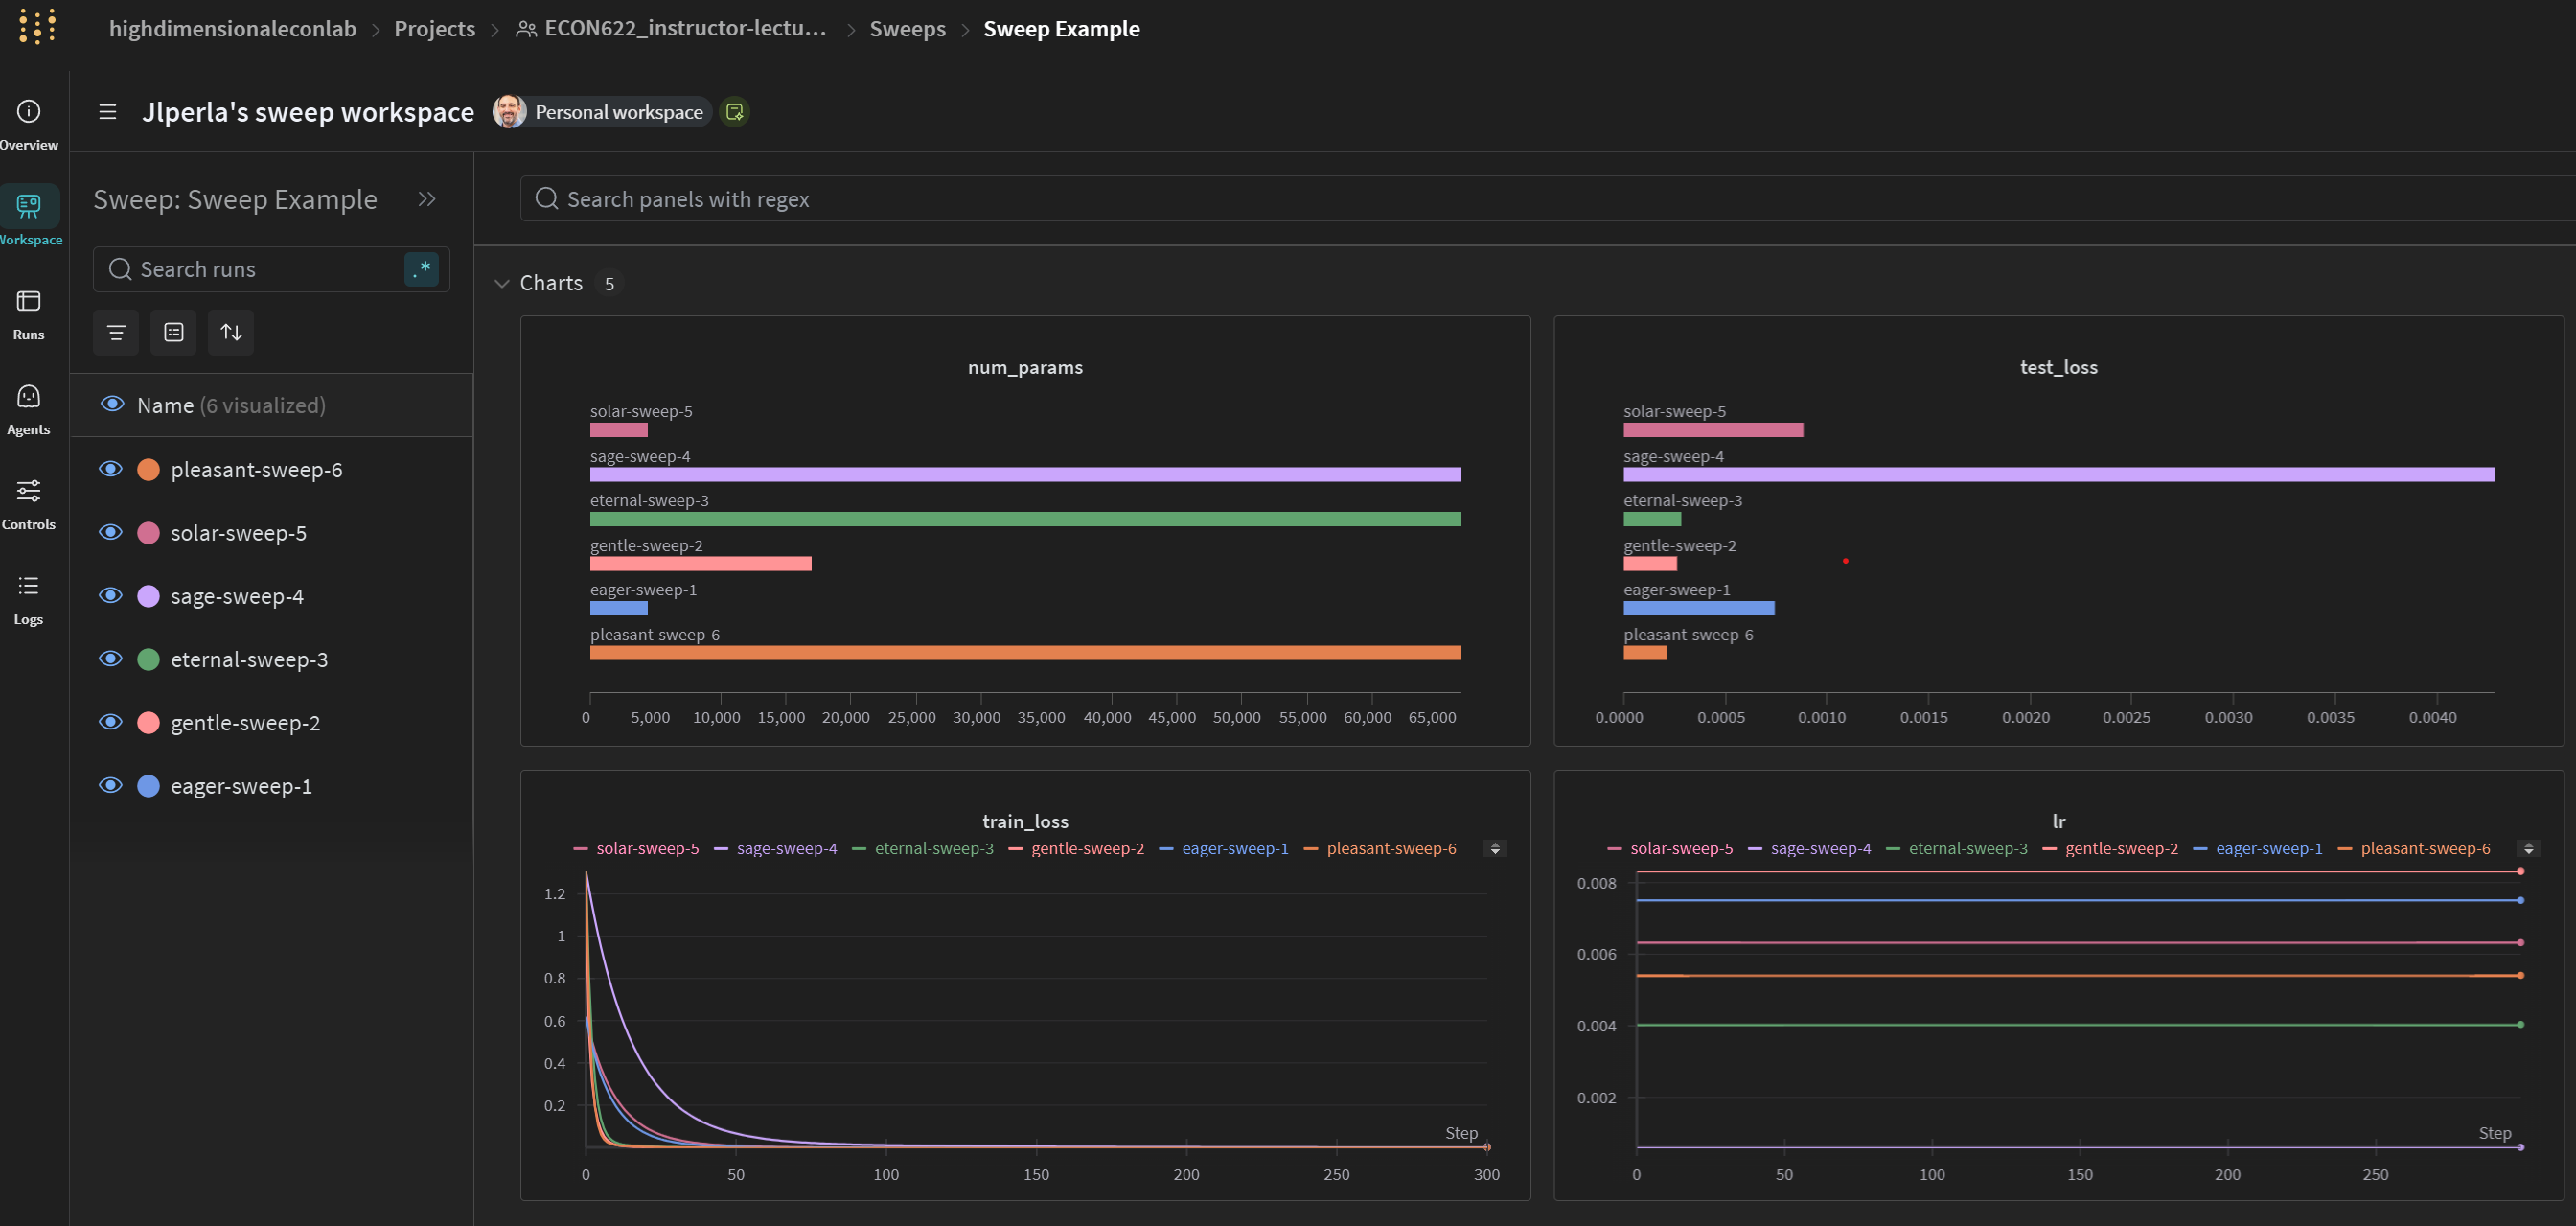

## Correlations of Parameters to HPO Objective

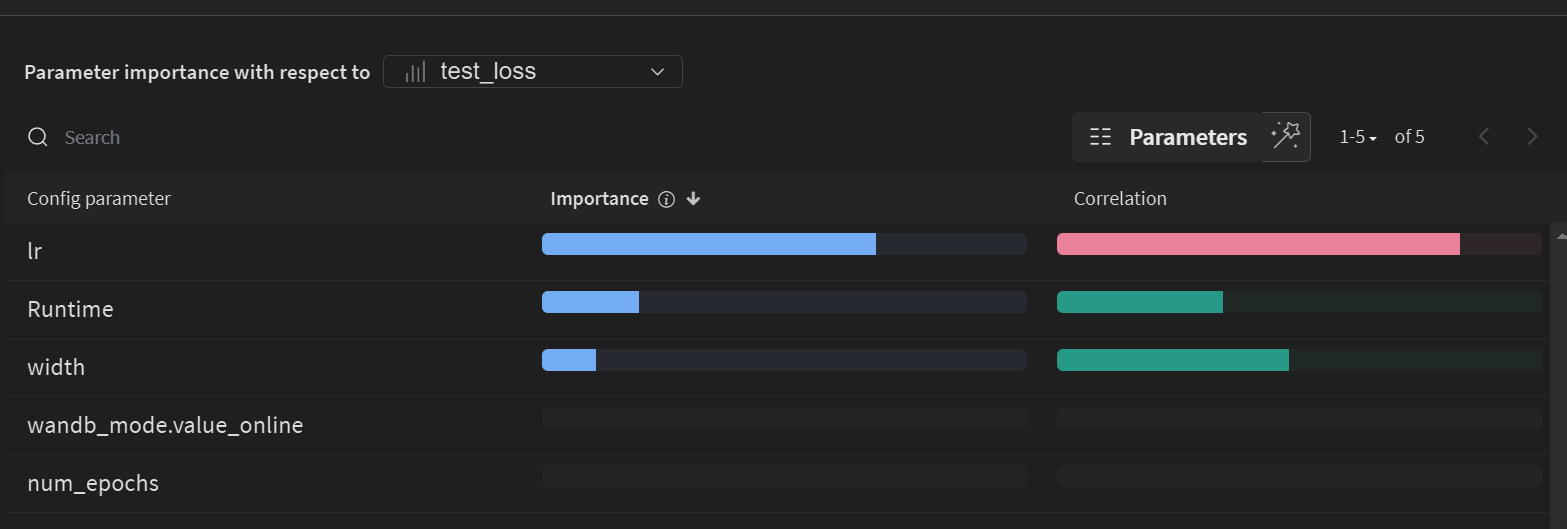

## Sortable Table of Results

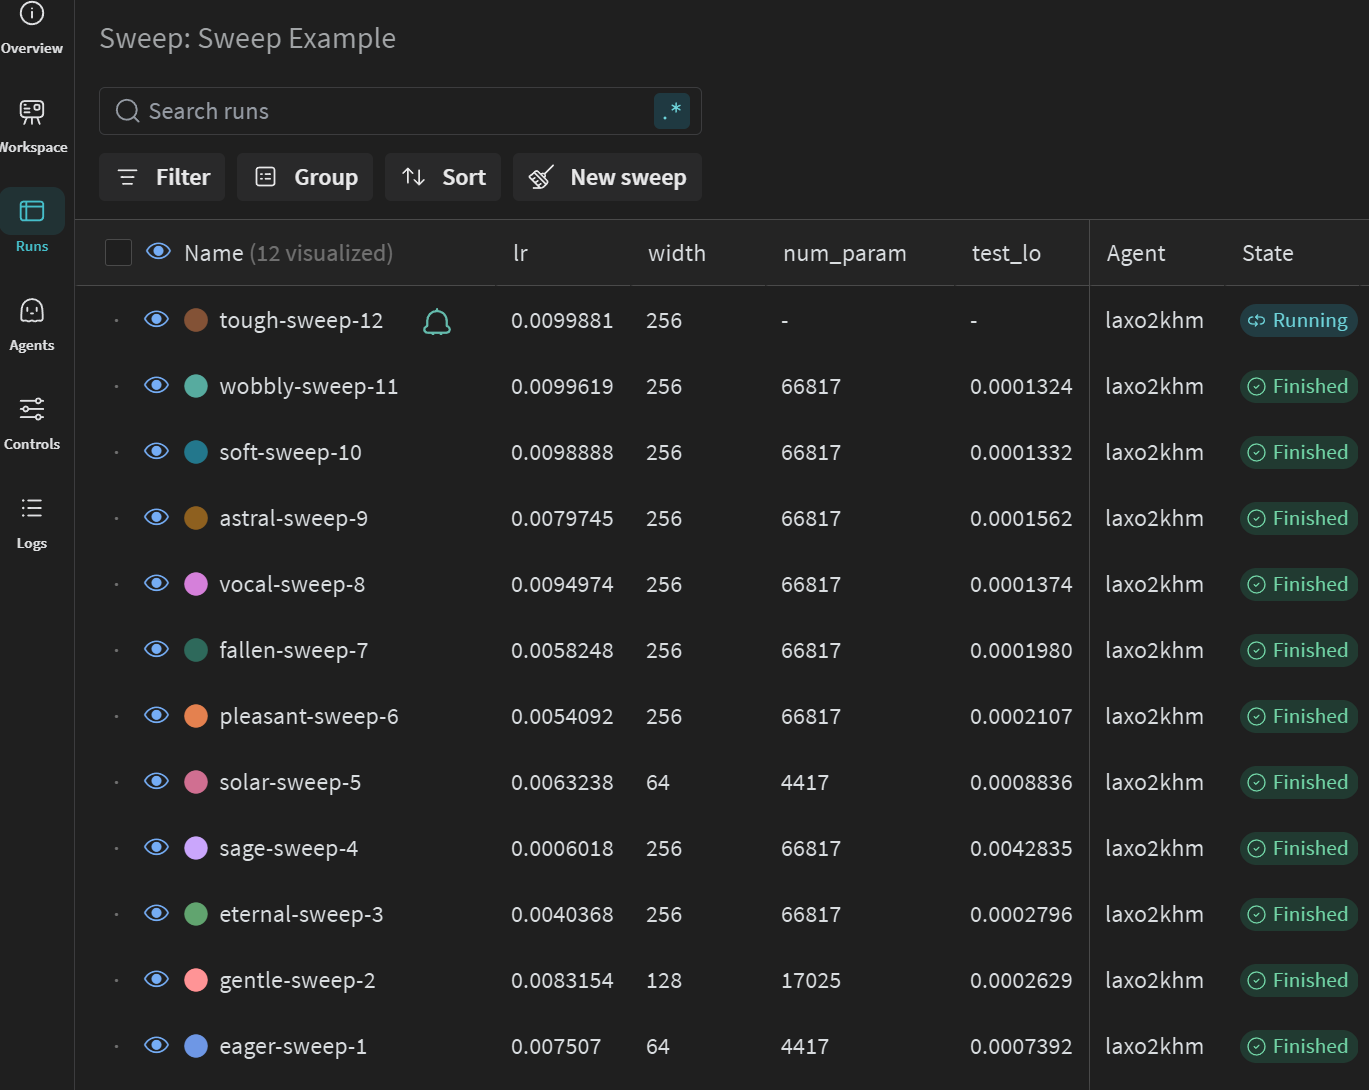